# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [1]:
# Add your imports here
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

In [2]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: 

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### A1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

*Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).*

In [3]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'

In [4]:
# Write your code here
themes = pd.read_csv(LEGO_DATA_FOLDER + '/themes.csv.zip') #, dtype={''}
colors = pd.read_csv(LEGO_DATA_FOLDER + '/colors.csv.zip')
inventories = pd.read_csv(LEGO_DATA_FOLDER + '/inventories.csv.zip')
inventory_parts = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_parts.csv.zip')
inventory_sets = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_sets.csv.zip')
part_categories = pd.read_csv(LEGO_DATA_FOLDER + '/part_categories.csv.zip')
parts = pd.read_csv(LEGO_DATA_FOLDER + '/parts.csv.zip')
sets = pd.read_csv(LEGO_DATA_FOLDER + '/sets.csv.zip')

### A2. Cleaning phase
Explore the following columns from your dataset:

1. sets: year
* inventory_parts: quantity

What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

time range of the sets:

In [5]:
print(sets.year.iloc[[0, 7, 11645, 11643]])

0           70s
7         19788
11645    -20122
11643     -2014
Name: year, dtype: object


In [6]:
# we define a function that deals with every one of those cases
# we assumed the following:
# 70s -> 1970
# negative year -> ignore negative sign
# 20122 -> the two last digits are redundant: remove the last one.
def read_year(year_s):
    try:
        year = int(year_s)
        if year < 0:
            year = -year
        if year > 2018:
            return read_year(year_s[:-1])
        else:
            return year
    except ValueError:
        return 1900 + read_year(year_s[:-1])
    
year_clean = sets.year.apply(read_year)

# as the resulted type is integers (-> no NAN values) and the range is reasonnable, data is coherent 
print('year type:', year_clean.dtype)
print('year min:', year_clean.min())
print('year max:', year_clean.max())

year type: int64
year min: 1950
year max: 2017


In [7]:
# there is only one kind of inconsistency in the inventory parts quantities
print(inventory_parts.quantity.iloc[[9]])

9   -inf
Name: quantity, dtype: float64


In [8]:
# to deal with those, we define a function that returns quantities as integers
# a reasonable default value on inconsistency is 0
def read_quantity(quantity):
    return 0 if quantity == float('-inf') else int(quantity)

quantity_clean = inventory_parts.quantity.apply(read_quantity)

# applying that function leads to no NAN values and the given mean
print('number of NAN values:', quantity_clean.map(np.isnan).sum())
print('parts quantity mean:', quantity_clean.mean())

number of NAN values: 0
parts quantity mean: 2.7670542575540584


__\* Briefly explain your approach here \*__

### A3. Querying phase
Answer the following queries using the functionality of `Pandas`:

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. What do you observe for the years 1980-1981? How do you interpret what you see?

\*The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

In [9]:
### Task A3.1: ids of the inventories that belong to sets that contain cars.
# We had to spot all car related keywords and brands used in the sets' names.
car_keywords = ['car', 'truck', 'Rolls-Royce' , 'Cadillac' , 'Renault' , 'Ford' , 'Berlinetta' , 'Audi' , 'Chevrolet' , 'Ferrari' , 'Lamborghini' , 'McLaren' , 'Mercedes' , 'Porsche' , 'VW' ]

# Based on those we discriminated car sets with the following method
# We remain careful about the case of strings by systematically lowering them.
car_keywords = list(map(lambda s: s.lower(), car_keywords))
def car(s):
    s = s.lower()
    for keyword in car_keywords:
        if(keyword in s):
            return True
    return False

# we then merge the filtered sets with the inventories and print the unique resulting inventoriy ids.
pd.merge(sets[sets.name.apply(car)], inventory_sets, left_on='id', right_on='set_id').inventory_id.unique()

array([13941, 10158, 13083,  5358, 13380,  8202, 12137, 10770, 10995,
        4536, 16131,  1716,  3755, 10406, 10993,  1645, 14174,  7430,
        9709, 14711, 12851, 10515, 14919,  2814, 15010, 16138,  5904,
        7151, 11966,  8140,  1726,  2643,  6066,  1649,  6530, 14011,
        2677,  5491,  2917,  6086, 10421, 16159,  9329, 11759,  1899,
        2849,  4643,  1371, 13427,  2836,  8950,   528, 14493,  9210,
         908,  2636, 11050, 11190,  9033,  1732,  3764,  1401,  4430,
        5110,  9178, 13355,  2559,  6296, 10028, 12110,  1205,  1418,
        3109,  4261,  4969,  5857, 11861, 15192, 15694, 13696,  7363,
        5432,  4051,  8820,   263,  5600,    35, 11935,  9426,  7881,
        9599, 10043, 16023, 16034,  9502, 13370, 14328, 14931,  4187,
       13398,  6702,  8348,  9406, 14154,  4278,   962,  6276, 11436,
        1334,  3435,  8331,  3699,  8980,  4832,  9381, 12830, 12437,
        4467,  2258,  8585,   500,  2114], dtype=int64)

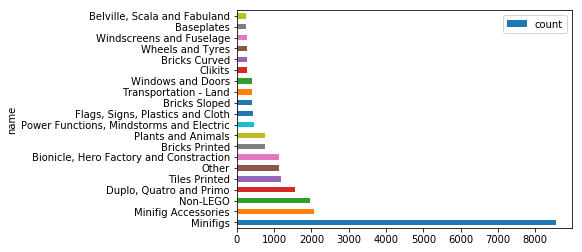

In [10]:
### Task A3.2: distribution of part categories
# get the count of parts for a category id
df = parts.groupby('part_cat_id').size().to_frame('count').reset_index('part_cat_id')
# keep the 20 largest
df = df.sort_values('count', ascending=False).head(20)
# merge with catogory name
df = pd.merge(df, part_categories, left_on='part_cat_id', right_on='id')
# plot the chart
df.plot.barh(x='name', y='count')

In [11]:
# define function to get actual (r,g,b) values from hex value
# this function is needed for Task A3.3 and A3.4.
def hex_to_rgb(hex):
    return tuple(int(hex[i:i+2], 16)/255 for i in (0, 2 ,4))

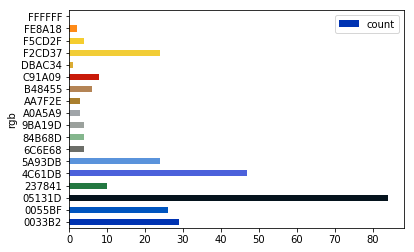

In [12]:
### Task A3.3.a: Find the dominant color of each set. 
# as the definition of what a 'dominant color' is isn't given, we'll assume the following:
# it is the color that hast the most number of parts with that color.
# so we'll need to compute, for each set, the number of parts wich each colors and take the one that is the more represented.
# get cleaned inventory_parts (after Task A2)
df = inventory_parts.copy().drop('quantity', axis='columns')
df['inventory_quantity'] = quantity_clean
# merge that with parts and keep only the needed columns
df = pd.merge(inventory_sets, df, on='inventory_id').drop(['is_spare', 'inventory_id', 'part_id'], axis='columns')
# compute the total number of parts and drop unnecessary columns
df['part_quantity'] = df.quantity * df.inventory_quantity
df.drop(['inventory_quantity', 'quantity'], axis='columns', inplace=True)
# get the best colors 
df = df.groupby(['set_id', 'color_id'])['part_quantity'].sum().reset_index()
df.iloc[df.groupby('set_id')['part_quantity'].idxmax()]
# merge with colors to get actual colors name and rgb
set_colors = pd.merge(df, colors, left_on='color_id', right_on='id')[['set_id', 'name', 'rgb']]

### Task A3.3.b Plot the number of sets per dominant color. Color each bar with the respective color that it represents.
# get the cout of set per color
df = set_colors.groupby('rgb').size().to_frame('count').reset_index('rgb')
# plot it
df.plot(kind='barh', x='rgb', y='count', color=map(lambda c: (hex_to_rgb(c)), df['rgb']))

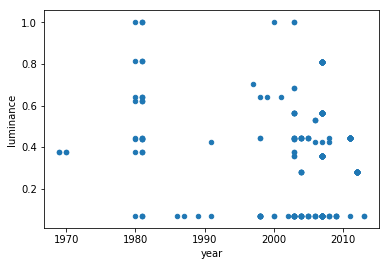

In [13]:
### Task A3.4: luminance* of the sets vs their publishing year
# define the luminance function
def luminance(hex):
    r,g,b = hex_to_rgb(hex)
    return np.sqrt(0.299*r*r + 0.587*g*g + 0.114*b*b)

# get cleaned year with associated color via set ids
df = sets.copy()[['id']]
df['year'] = year_clean
df = pd.merge(df, set_colors, left_on='id', right_on='set_id')

# compute luminance
df['luminance'] = df.rgb.map(luminance)

# plot it
df.plot.scatter(x='year', y='luminance')
# we can observe that the luminance as well as the number of set published per year is going down for the last 20 years

In first part we go through the data and find all the names of car brands and store them in the list keywords.
After that we go through the data and list all ids of sets which contain car name in it.

In second part

In the last part we see that luminance decreases during last few years and we have fewer sets in those years(after 2010).

## Task B. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this task you will again perform data wrangling and interpretation.

### B1. Loading phase
Load the json file into a `DataFrame`.


In [14]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

In [15]:
import numpy as np 
import pandas as pd
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

ori_bikes = pd.read_json(BIKES_DATA_FOLDER+"/metro-bike-share-trip-data.json.zip",compression="zip")
normal_ori_bikes = ori_bikes[ori_bikes["Passholder Type"]!="Staff Annual"].reset_index()
data_bikes = normal_ori_bikes.dropna(how="any")
nan_vals = normal_ori_bikes.iloc[list(set(normal_ori_bikes.index)-set(data_bikes.index))]

print ("%d staff trips, %d missing info trips"%(ori_bikes[ori_bikes["Passholder Type"]=="Staff Annual"].shape[0],
                                               len(nan_vals)))
print("Total number of trips: %d" %ori_bikes.shape[0])

382 staff trips, 1330 missing info trips
Total number of trips: 132427


In [16]:
data_bikes["Bike ID"] = data_bikes["Bike ID"].astype("int")
data_bikes["Starting Station ID"] = data_bikes["Starting Station ID"].astype("int")
data_bikes["Ending Station ID"] = data_bikes["Ending Station ID"].astype("int")
data_bikes["Plan Duration"] = data_bikes["Plan Duration"].astype("int")
data_bikes["Start Time"] = [datetime.strptime(x,'%Y-%m-%dT%X') for x in data_bikes["Start Time"]]
data_bikes["End Time"] = [datetime.strptime(x,'%Y-%m-%dT%X') for x in data_bikes["End Time"]]
data_bikes.head(2)

,index,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
0,0,6281,180,2016-07-07 04:20:00,3014,34.05661,-118.23721,Monthly Pass,30,2016-07-07 04:17:00,3014,34.05661,-118.23721,1912818,Round Trip
1,1,6281,1980,2016-07-07 06:33:00,3014,34.05661,-118.23721,Monthly Pass,30,2016-07-07 06:00:00,3014,34.05661,-118.23721,1919661,Round Trip


### B2. Cleaning phase
Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

In [17]:
print("Float Based Variables:")
data_bikes[["Duration",
            "Starting Station Latitude","Starting Station Longitude",
            "Ending Station Latitude","Ending Station Longitude"]].describe(include = "all")

Float Based Variables:


,Duration,Starting Station Latitude,Starting Station Longitude,Ending Station Latitude,Ending Station Longitude
count,130715.000000,130715.000000,130715.000000,130715.000000,130715.000000
mean,1355.489577,34.039217,-118.221174,34.034565,-118.206422
std,4674.172366,0.532694,1.849996,0.652348,2.265617
min,60.000000,0.000000,-118.472832,0.000000,-118.472832
25%,360.000000,34.044170,-118.256980,34.044159,-118.256981
50%,600.000000,34.046822,-118.250954,34.046810,-118.250954
75%,1080.000000,34.050880,-118.241562,34.050480,-118.238810
max,86400.000000,34.064281,0.000000,34.064281,0.000000


In [18]:
print("TimeStamp Based Variables:")
data_bikes[["Start Time","End Time"]].describe()

TimeStamp Based Variables:


,Start Time,End Time
count,130715,130715
unique,96991,89870
top,2016-07-14 11:38:00,2016-08-13 13:42:00
freq,15,14
first,2016-07-07 04:17:00,2016-07-07 04:20:00
last,2017-03-31 23:45:00,2017-04-01 18:15:00


In [19]:
print("Categorical Variables: ")
categorical_vars = ["Trip Route Category","Bike ID","Trip ID","Passholder Type","Ending Station ID","Starting Station ID","Plan Duration"]
for k in categorical_vars:
    data_bikes[k] = data_bikes[k].astype('category') 

data_bikes[categorical_vars].describe()

Categorical Variables: 


,Trip Route Category,Bike ID,Trip ID,Passholder Type,Ending Station ID,Starting Station ID,Plan Duration
count,130715,130715,130715,130715,130715,130715,130715
unique,2,762,130715,3,66,66,3
top,One Way,4727,23732455,Monthly Pass,3005,3069,30
freq,118083,309,1,80517,6245,5059,80517


In [20]:
redundancies = data_bikes[["Duration","Trip Route Category","Plan Duration"]]
data_non_redundant = data_bikes.drop(["Duration","Trip Route Category","Plan Duration"],axis=1)
print("Redundant Columns: ")
print("\t Shape:  %s"%str(redundancies.shape))
print("\t Dtypes : %s"%str(redundancies.dtypes).replace("\n","\n\t\t"))
print("\nNon-Redundant Data: ")
print("\t Shape:  %s"%str(data_non_redundant.shape)) 
print("\t Dtypes : %s"%str(data_non_redundant.dtypes).replace("\n","\n\t\t"))

Redundant Columns: 
	 Shape:  (130715, 3)
	 Dtypes : Duration                  int64
		Trip Route Category    category
		Plan Duration          category
		dtype: object

Non-Redundant Data: 
	 Shape:  (130715, 12)
	 Dtypes : index                                  int64
		Bike ID                             category
		End Time                      datetime64[ns]
		Ending Station ID                   category
		Ending Station Latitude              float64
		Ending Station Longitude             float64
		Passholder Type                     category
		Start Time                    datetime64[ns]
		Starting Station ID                 category
		Starting Station Latitude            float64
		Starting Station Longitude           float64
		Trip ID                             category
		dtype: object


__\* Briefly explain your approach here \*__

### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

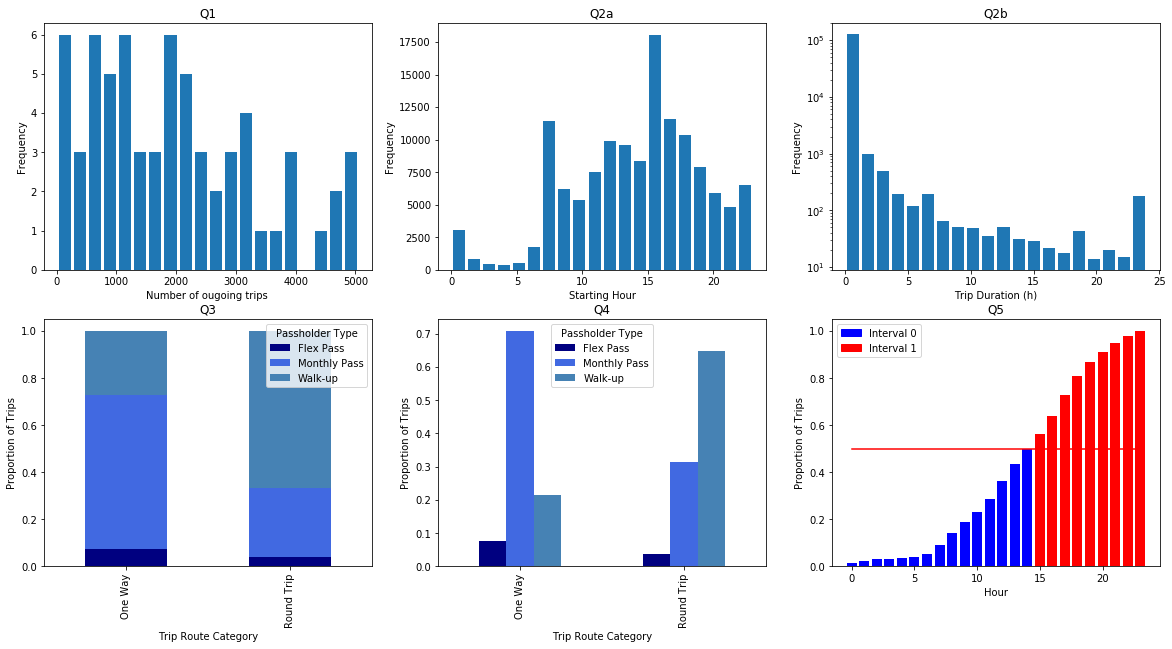

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter

% matplotlib inline

colors= ["navy","royalblue","steelblue","lightsteelblue"]
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,10))

axes[0,0].hist(list(Counter(data_bikes["Starting Station ID"]).values()),bins=20,rwidth = 0.8);
axes[0,0].set_xlabel("Number of ougoing trips ");
axes[0,0].set_ylabel("Frequency");
axes[0,0].set_title("Q1");

time_start = [x.hour for x in data_bikes["Start Time"]]
axes[0,1].hist(time_start,bins=20,rwidth = 0.8);
axes[0,1].set_xlabel("Starting Hour");
axes[0,1].set_ylabel("Frequency");
axes[0,1].set_title("Q2a");

durations = data_bikes["Duration"]//3600
axes[0,2].hist(durations,bins=20,rwidth = 0.8,log=True);
axes[0,2].set_xlabel("Trip Duration (h)");
axes[0,2].set_ylabel("Frequency");
axes[0,2].set_title("Q2b");

x = (data_bikes.groupby(["Trip Route Category","Passholder Type",])).size().groupby(level=0).apply(
    lambda x:  x / x.sum()
)
x.unstack().plot(kind='bar',stacked=True, color=colors, grid=False,ax=axes[1,0]);
axes[1,0].set_ylabel("Proportion of Trips");
axes[1,0].set_title("Q3");

noon = 12
x = (data_bikes[[x.hour < noon for x in data_bikes["Start Time"]]].groupby(["Trip Route Category","Passholder Type",])).size().groupby(level=0).apply(
    lambda x:  x / x.sum()
)
x.unstack().plot(kind='bar',stacked=False, color=colors, grid=False,ax=axes[1,1]);
axes[1,1].set_ylabel("Proportion of Trips");
axes[1,1].set_title("Q4");

sta_hr = Counter([x.hour for x in data_bikes["Start Time"]])
red_patch = mpatches.Patch(color='red', label='Interval 1')
blue_patch = mpatches.Patch(color='blue', label='Interval 0')

df = pd.DataFrame.from_dict(list(sta_hr.items()))
df.columns = ['Hour', 'Trips']
df.set_index('Hour',inplace=True)
df.sort_index(inplace=True)
new_df = (df.cumsum()/df.sum()).reset_index()
axes[1,2].bar(new_df.Hour,new_df.Trips,color = ["red" if k>14 else "blue"for k in range(24)  ]);
axes[1,2].plot([0,23],[0.5,0.5],"red")
axes[1,2].set_xlabel("Hour");
axes[1,2].set_ylabel("Proportion of Trips");
axes[1,2].legend(handles=[blue_patch,red_patch]);
axes[1,2].set_title("Q5");# Write your code here

In [22]:

hour_threshold = 14
data_bikes["Hour Category"] = [int(x.hour<=hour_threshold) for x in data_bikes["Start Time"]]
x = (data_bikes.groupby(["Trip Route Category","Hour Category","Passholder Type",])).size().groupby(level=0).apply(
    lambda x:  x / x.sum()
).unstack()
x.div(x.sum(axis=1), axis=0)

Passholder Type                    Flex Pass  Monthly Pass   Walk-up
Trip Route Category Hour Category                                   
One Way             0               0.074338      0.641012  0.284650
                    1               0.077657      0.660005  0.262339
Round Trip          0               0.034891      0.273612  0.691496
                    1               0.041422      0.311747  0.646832

__\* Briefly explain your approach for every query here \*__